In [1]:
from keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D, BatchNormalization, LeakyReLU
from keras.layers.merging import concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imsave
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import io
from PIL import Image, ImageFilter
import cv2
import os
import requests
import pandas as pd
from urllib.request import urlopen

c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [2]:
from keras.layers.regularization.spatial_dropout3d import Dropout
from keras.layers.activation.prelu import PReLU
from keras.layers.reshaping.cropping2d import Cropping2D

In [3]:
path = "photos/train/"
testPath = "photos/test/"

In [42]:
train_gen = ImageDataGenerator(rescale=1./255)
train = train_gen.flow_from_directory(path, target_size=(256,256), batch_size=25, class_mode=None)

Found 1500 images belonging to 1 classes.


In [43]:
test_gen = ImageDataGenerator(rescale=1./255)
test = test_gen.flow_from_directory(testPath, target_size=(256, 256), batch_size=25, class_mode=None)

Found 1500 images belonging to 1 classes.


# Previous Work

In [78]:
def rgb_2_gray(image):
    return np.dot(image[..., :3], [0.299, 0.587, 0.114])

In [79]:
def prepImage(path):
    color_img = []
    bw_img = []
    for imageDir in os.listdir(path):
        try:
            img = cv2.imread(path+imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img = cv2.resize(img, (256,256))
            img = img.astype('float32') / 255.0

            color_img.append(img_to_array(img))

            bw_img.append(rgb_2_gray(img_to_array(img)))
        
        except:
            pass

        return np.array(bw_img), np.array(color_img)

In [80]:
def ExtractInput(path):
    X_img=[]
    y_img=[]
    i=0

    for imageDir in os.listdir(path):
        try:
            img = cv2.imread(path + imageDir)
#            img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LINEAR) # resize image to network input size
#            plt.imshow(img)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          #  plt.imshow(img)
         #   img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
           # img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

     #       kernel = np.ones((4,4),np.float32)/16
    #        img = cv2.filter2D(img,-1,kernel)
           # img = cv2.GaussianBlur(img,(5,5),0)
    
            img = img.astype(np.uint8)
            img_lab = rgb2lab(img)
#            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            
            #Convert the rgb values of the input image to the range of 0 to 1
            #1.0/255 indicates that we are using a 24-bit RGB color space.
            #It means that we are using numbers between 0–255 for each color channel
            img_lab = 1.0/225*img_lab
            # resize the lightness channel to network input size 
            #img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab[:,:,0] # pull out L channel
            #img_l -= 50 # subtract 50 for mean-centering
            img_ab = img_lab[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [81]:
def ExtractTestInput(img):
    print("changing colors")
    img = img[:,:,:3]
    print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape)

    img_ = rgb2lab(img)
    
    img_=img_.astype(np.float32)
    print('image converted')
    img_lab_rs = cv2.resize(img_, (256, 256)) # resize image to network input size
    print("image resized")
    img_l = img_lab_rs[:,:,0] # pull out L channel
    #img_l -= 50
    img_l_reshaped = img_l.reshape(1,256,256,1)
    print("luminance reshaped")
 #   else:
  #    return "invalid image"
    
    return img_l_reshaped

In [82]:
X_,y_ = ExtractInput(path+"train_data/") # Data-preprocessing

In [12]:
X_test, y_test = ExtractInput(testPath+"test_data/")

In [13]:
X_[0].shape

(256, 256)

In [14]:
y_[0].shape

(256, 256, 2)

In [15]:
X_test[0].shape

(256, 256)

In [137]:
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = PReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = PReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = PReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = PReLU()(model_)
    model_ = BatchNormalization()(model_)
    
#    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
 #   model_ = PReLU()(model_)
  #  model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = PReLU()(model_)
    model_ = BatchNormalization()(model_)
    
#    model_ = UpSampling2D((2, 2))(model_)
#    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
#    model_ = PReLU()(model_)
 #   model_ = BatchNormalization()(model_)
    
 #   concat_ = concatenate([model_, in_]) 
    
#    model_ = Conv2D(128,(3,3), padding='same',strides=1)(concat_)
 #   model_ = PReLU()(model_)
  #  model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = PReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(model_)
    model_ = PReLU()(model_)
    model_ = BatchNormalization()(model_)

    concat_ = concatenate([model_, in_])
    
    model_ = Conv2D(2,(3,3), activation='sigmoid',padding='same',strides=1)(model_)

    return model_

In [17]:
Input_Sample = Input(shape=(256, 256,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_) #Model groups layers into an object with training and inference features.

In [ ]:
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error',
                            metrics=["accuracy"])
Model_Colourization.summary()

In [ ]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)

Model_Colourization.fit(GenerateInputs(X_,y_),epochs=12,verbose=1, steps_per_epoch=8,shuffle=True, validation_data=(X_test, y_test))

In [ ]:
ImagePath="photos/test/test_data/8R0l7vkXTXk.jpg"
img = cv2.imread(ImagePath)
print(img.shape)
print("Loaded image")
image_for_test = ExtractTestInput(img)
print("Extracted output")
#print(image_for_test)
Prediction = Model_Colourization.predict(image_for_test)
print("Prediction made")
Prediction = Prediction*128
Prediction=Prediction.reshape(256,256,2)
print("reshaped")

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(ImagePath)
#img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
#img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (256, 256))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
#img = cv2.GaussianBlur(img,(5,5),0)
#kernel = np.ones((3,3),np.float32)/16
#img = cv2.filter2D(img,-1,kernel)
#plt.imshow(img)

img_bw = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img_bw, cmap="gray")
img_ = rgb2lab(img)
img_bw = img_[:,:,0]
#img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
print(img_)
img_[:,:,1:] = Prediction
print(img_)
#img_[:,:,1] = Prediction[0]
#img_[:,:,2] = Prediction[1]
img_ = lab2rgb(img_)
#img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
#img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)
plt.subplot(5,5,1+1)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img)

# New Attempt

In [76]:
HEIGHT=256
WIDTH=256
ImagePath="photos/train/train_data/"

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [77]:
X_,y_ = ExtractInput(ImagePath) # Data-preprocessing

In [78]:
X_test, y_test = ExtractInput(testPath+"test_data/")

In [79]:
X_[0].shape

(256, 256)

In [80]:
X_test[0].shape

(256, 256)

In [81]:
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [82]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [83]:
LEARNING_RATE = 0.0005
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error')
Model_Colourization.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 256, 256, 16  160         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_36 (LeakyReLU)     (None, 256, 256, 16  0           ['conv2d_40[0][0]']              
                                )                                                           

c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 ormalization)                  )                                                                 
                                                                                                  
 conv2d_48 (Conv2D)             (None, 256, 256, 32  18464       ['batch_normalization_29[0][0]'] 
                                )                                                                 
                                                                                                  
 leaky_re_lu_44 (LeakyReLU)     (None, 256, 256, 32  0           ['conv2d_48[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 256, 256, 2)  578         ['leaky_re_lu_44[0][0]']         
                                                                                                  
Total para

In [108]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)
Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=30)

Epoch 1/12


C:\Users\jrsco\AppData\Local\Temp\ipykernel_28080\1642284006.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=30)


5/5 [==============================] - 30s 7s/step - loss: 0.0212 - val_loss: 0.5995
Epoch 2/12
5/5 [==============================] - 19s 4s/step - loss: 0.0242 - val_loss: 0.7684
Epoch 3/12
5/5 [==============================] - 17s 4s/step - loss: 0.0315 - val_loss: 0.6809
Epoch 4/12
5/5 [==============================] - 18s 4s/step - loss: 0.0417 - val_loss: 0.7136
Epoch 5/12
5/5 [==============================] - 19s 4s/step - loss: 0.0141 - val_loss: 0.8928
Epoch 6/12
5/5 [==============================] - 17s 4s/step - loss: 0.0315 - val_loss: 0.6456
Epoch 7/12
5/5 [==============================] - 19s 4s/step - loss: 0.0126 - val_loss: 0.6434
Epoch 8/12
5/5 [==============================] - 22s 5s/step - loss: 0.0095 - val_loss: 0.4884
Epoch 9/12
5/5 [==============================] - 20s 5s/step - loss: 0.0061 - val_loss: 0.3874
Epoch 10/12
5/5 [==============================] - 19s 4s/step - loss: 0.0041 - val_loss: 0.3514
Epoch 11/12
5/5 [==============================] -

In [109]:
def ExtractTestInput(img):
#    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    #img_l -= 50
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped

In [120]:
TestImagePath="photos/test/test_data/Lq019pp20uA.jpg"
TestImagePath="photos/test/test_data/4V8JxijgZ_c.jpg"

img = cv2.imread(TestImagePath)
print(img.shape)
print("Loaded image")
image_for_test = ExtractTestInput(img)
print("Extracted output")
#print(image_for_test)
Prediction = Model_Colourization.predict(image_for_test)
print("Prediction made")
Prediction = Prediction*128
Prediction=Prediction.reshape(256,256,2)
print("reshaped")

(256, 256, 3)
Loaded image
Extracted output
1/1 [==============================] - 0s 256ms/step
Prediction made
reshaped


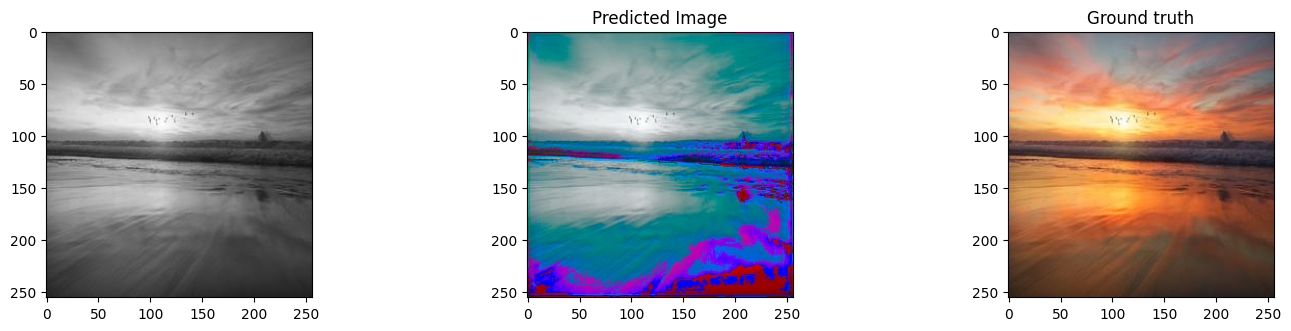

In [121]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)